# Unfolding Model based on Mumford-Shah for Super-Resolution

## Prepare dependencies

### Clone repo

In [24]:
!git clone https://github.com/merveille-dona/Pytorch-MumfordShahSR.git
!mv Pytorch-MumfordShahSR/* .
!rm -rf Pytorch-MumfordShahSR

Cloning into 'Pytorch-MumfordShahSR'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 51 (delta 25), reused 23 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 1.83 MiB | 4.23 MiB/s, done.
Resolving deltas: 100% (25/25), done.


### Install dependencies

In [25]:
!pip install git+https://github.com/akhaten/lasp.git@6d3d7192d624a636cfbab682c4a0585d7738acc8
!pip install \
    torch \
    pytorch-ignite \
    numpy \
    pandas \
    scipy \
    matplotlib

  Cloning https://github.com/akhaten/lasp.git (to revision 6d3d7192d624a636cfbab682c4a0585d7738acc8) to /tmp/pip-req-build-_py4bhng
  Running command git clone --filter=blob:none --quiet https://github.com/akhaten/lasp.git /tmp/pip-req-build-_py4bhng
  Running command git rev-parse -q --verify 'sha^6d3d7192d624a636cfbab682c4a0585d7738acc8'
  Running command git fetch -q https://github.com/akhaten/lasp.git 6d3d7192d624a636cfbab682c4a0585d7738acc8
  Running command git checkout -q 6d3d7192d624a636cfbab682c4a0585d7738acc8
  Resolved https://github.com/akhaten/lasp.git to commit 6d3d7192d624a636cfbab682c4a0585d7738acc8
  Preparing metadata (setup.py) ... done


### Imports

#### Lasp

Github : https://github.com/akhaten/lasp

In [26]:
import lasp.io
import lasp.filters.linear
import lasp.utils
import lasp.noise
import lasp.convert
from lasp.geometry import *

#### Torch

In [27]:
import torch
import ignite.metrics

#### Others

In [28]:
import pathlib
import numpy
import pandas
import scipy.signal
import matplotlib.pyplot

## Define constant

In [29]:
CMAP = 'gray'

## Make dataset

### Make Piecewise Image

In [30]:
# Value for background image
BACKGROUNG = 1.0
# Value for geometry form
GEOMETRY = 0.5

In [31]:
def piece_wise_1():

    img = numpy.full(shape=(512, 512), fill_value=BACKGROUNG, dtype=numpy.float64)

    img = make_square(
        img = img,
        p1 = numpy.array([100, 100]),
        p2 = numpy.array([200, 200]),
        value=GEOMETRY
    )
    img = make_circle(img, numpy.array([100, 300]), 40, value=GEOMETRY)
    img = make_star(img, numpy.array([300, 300]), numpy.array([300, 300]) + 200, value=GEOMETRY)

    return img

In [32]:
def piece_wise_2():

    img = numpy.full(shape=(512, 512), fill_value=BACKGROUNG, dtype=numpy.float64)

    img = make_triangle(
        img,
        p1 = numpy.array([200, 100]),
        p2 = numpy.array([250, 300]),
        p3 = numpy.array([150, 300]),
        value=GEOMETRY
    )
    img = make_circle(img, numpy.array([300, 300]), 40, value=GEOMETRY)
    img = make_star(img, numpy.array([100, 300]), numpy.array([100, 300]) + 200, value=GEOMETRY)

    return img

In [33]:
def piece_wise_3():

    img = numpy.full(shape=(512, 512), fill_value=BACKGROUNG, dtype=numpy.float64)
    xi = numpy.array([100, 100])
    yi = xi + 100

    img = make_triangle(
        img,
        p1 = numpy.array([100, 10]),
        p2 = numpy.array([100, 100]),
        p3 = numpy.array([150, 300]),
        value=1.0
    )

    img = make_partial_circle(img, numpy.array([400, 100]), 40, 50, value=GEOMETRY)
    img = make_star(img, numpy.array([100, 300]), numpy.array([100, 300]) + 100, value=GEOMETRY)

    img = make_star(img, numpy.array([300, 300]), numpy.array([300, 300]) + 100, value=GEOMETRY)

    return img

In [34]:
def piece_wise_4():

    img = numpy.full(shape=(512, 512), fill_value=BACKGROUNG, dtype=numpy.float64)

    img = make_partial_circle(
        img = img,
        center = numpy.array([100, 100]),
        radius_min = 20,
        radius_max = 40,
        value=GEOMETRY
    )

    img = make_circle(
        img = img,
        center = numpy.array([200, 200]),
        radius = 40,
        value=GEOMETRY
    )


    img = make_partial_circle(
        img = img,
        center = numpy.array([100, 300]),
        radius_min = 20,
        radius_max = 40,
        value=GEOMETRY
    )

    img = make_circle(
        img = img,
        center = numpy.array([200, 300]),
        radius = 40,
        value=GEOMETRY
    )

    img = make_square(
        img = img,
        p1 = numpy.array([300, 400]),
        p2 = numpy.array([400, 500]),
        value=GEOMETRY
    )

    img = make_partial_circle(
        img = img,
        center = numpy.array([400, 400]),
        radius_min = 50,
        radius_max = 80,
        value=BACKGROUNG
    )

    return img

In [35]:
img1 = piece_wise_1()
img2 = piece_wise_2()
img3 = piece_wise_3()
img4 = piece_wise_4()
imgs = [ img1, img2, img3, img4 ]

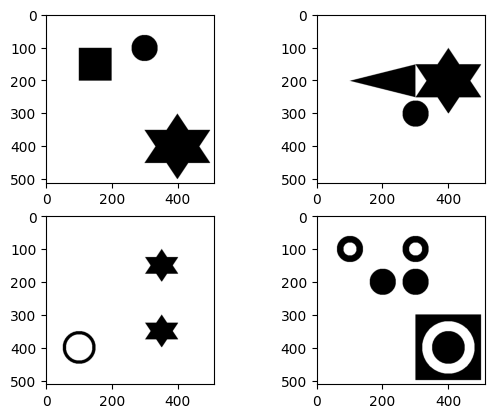

In [36]:
figure = matplotlib.pyplot.figure()

matplotlib.pyplot.subplot(2, 2, 1)
_ = matplotlib.pyplot.imshow(img1, cmap=CMAP)

matplotlib.pyplot.subplot(2, 2, 2)
_ = matplotlib.pyplot.imshow(img2, cmap=CMAP)

matplotlib.pyplot.subplot(2, 2, 3)
_ = matplotlib.pyplot.imshow(img3, cmap=CMAP)

matplotlib.pyplot.subplot(2, 2, 4)
_ = matplotlib.pyplot.imshow(img4, cmap=CMAP)

figure.show()

In [37]:
IMAGES_PATH = pathlib.Path('./Images')
if not(IMAGES_PATH.exists()):
    IMAGES_PATH.mkdir()

In [38]:
for i in range(0, len(imgs)):
    lasp.io.save(imgs[i], IMAGES_PATH / '{}.npy'.format(i))

### Make Dataframe and Degradation(s)

#### Setup paths

In [39]:
IMAGES_PATH = pathlib.Path('./Images')
GENERATION_PATH = pathlib.Path('./dataset_v1')

INPUT = GENERATION_PATH / 'input'
GROUND_TRUTH = GENERATION_PATH / 'ground_truth'
PLOTS = GENERATION_PATH / 'plots'

if not(GENERATION_PATH.exists()):
    GENERATION_PATH.mkdir()
if not(INPUT.exists()):
    INPUT.mkdir()
if not(GROUND_TRUTH.exists()):
    GROUND_TRUTH.mkdir()
if not(PLOTS.exists()):
    PLOTS.mkdir()

IMG_GEN_PKL = GENERATION_PATH / 'df_imgs.pkl'

#### Make Dataframe

In [40]:
def add_image(
    df_imgs: pandas.DataFrame,
    original: pathlib.Path,
    blur: tuple[int, int] = (0, 0),
    decimation: int = 1,
    noise: float = -1,
    noise_db: float = -1
) -> pandas.DataFrame :
    to_add = pandas.DataFrame(
        {
            'original': [original],
            'blur' : [blur],
            'decimation': [decimation],
            'noise (not dB)': [noise],
            'noise (dB)': [noise_db]
        }
    )
    return pandas.concat([df_imgs,  to_add], ignore_index=True)

In [41]:
df_imgs = pandas.DataFrame(columns=[ 'original', 'blur', 'decimation', 'noise (not dB)', 'noise (dB)' ])
noise = lasp.convert.snrdb_to_snr(60)

for i in range(1, 3):

    decimation = 2**i

    for img in IMAGES_PATH.glob('*'):

            # for snr_db in [ 10, 20, 30, 40, 50, 60 ]:
            for snr_db in range(20, 40, 5):

                noise = lasp.convert.snrdb_to_snr(snr_db)
                #
                #for blur in [ (7, 3), (9, 3), (15, 3), (21, 3), (45, 3) ]:

                    #df_imgs = add_image(df_imgs, img, blur, decimation, noise, snr_db)
                for size_sigma in range(10, 40, 5):

                    df_imgs = add_image(df_imgs, img, (size_sigma, size_sigma), decimation, noise, snr_db)
df_imgs

/tmp/ipython-input-1484004995.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pandas.concat([df_imgs,  to_add], ignore_index=True)


,original,blur,decimation,noise (not dB),noise (dB)
0,Images/0.npy,"(10, 10)",2,100.00000,20
1,Images/0.npy,"(15, 15)",2,100.00000,20
2,Images/0.npy,"(20, 20)",2,100.00000,20
3,Images/0.npy,"(25, 25)",2,100.00000,20
4,Images/0.npy,"(30, 30)",2,100.00000,20
...,...,...,...,...,...
187,Images/2.npy,"(15, 15)",4,3162.27766,35
188,Images/2.npy,"(20, 20)",4,3162.27766,35
189,Images/2.npy,"(25, 25)",4,3162.27766,35
190,Images/2.npy,"(30, 30)",4,3162.27766,35


In [42]:
def make_images(df_imgs: pandas.DataFrame) -> None:

    for index in df_imgs.index:

        # CURRENT = save_path / str(index)
        # if not(CURRENT.exists()):
        #     CURRENT.mkdir()


        img_datas = df_imgs.loc[index]

        img_path = img_datas['original']
        blur = img_datas['blur']
        decim = img_datas['decimation']
        noise = img_datas['noise (not dB)']
        noise_db = img_datas['noise (dB)']


        out = lasp.io.read(img_path) # x
        ground_truth_normalized = lasp.utils.normalize(out)
        lasp.io.save(ground_truth_normalized, GROUND_TRUTH / '{}.npy'.format(index))
        #lasp.io.save(out, GROUND_TRUTH / '{}.png'.format(index))

        title = ''

        if (blur[0] > 0) and (blur[1] > 0):
            kernel = lasp.filters.linear.gaussian_filter(size=blur[0], sigma=blur[1]) # Hx
            out = scipy.signal.convolve2d(out, kernel, mode='same')
            blur_str = 'Blur filter : {}x{}, $\sigma$={}\n'.format(blur[0], blur[0], blur[1])
            title += blur_str

        if decim > 0:
            out = lasp.utils.decimation(out, decim) # SHx
            decim_str = 'Decimation: {}x{}\n'.format(decim, decim)
            title += decim_str


        if noise >= 0:
            out = lasp.noise.awgn(out, noise) # SHx + n
            noise_str = 'Noise : {} (not dB)\n'.format(noise)
            noisedb_str = 'Noise : {} (dB)\n'.format(noise_db)
            title += noise_str
            title += noisedb_str


        normalized = lasp.utils.normalize(out)
        lasp.io.save(normalized, INPUT / '{}.npy'.format(index))
        #lasp.io.save(normalized, INPUT / '{}.png'.format(index))

        # Dont show figure in output
        # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ioff.html

        with matplotlib.pyplot.ioff():

          figure = matplotlib.pyplot.figure()

          # figure.subplots_adjust(top=1.4)


          figure.suptitle(title)
          # figure.tight_layout()

          # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

          ax = figure.subplots(1, 2)

          # ax[0].axis('off')
          ax[0].set_title('Normalized Input')
          ax[0].imshow(normalized, cmap='gray')


          # ax[1].axis('off')
          ax[1].set_title('Normalized Ground Truth')
          ax[1].imshow(ground_truth_normalized, cmap='gray')

          _ = figure.savefig(PLOTS / ('{}.png'.format(index)))
          _ = matplotlib.pyplot.close()

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-349135290.py:29: SyntaxWarning: invalid escape sequence '\s'
  blur_str = 'Blur filter : {}x{}, $\sigma$={}\n'.format(blur[0], blur[0], blur[1])


#### Make and save images

In [43]:
make_images(df_imgs)
pandas.to_pickle(df_imgs, IMG_GEN_PKL)

## Make configuration

In [44]:
config = {
  'dataset' : {
    'device' : 'cuda:0',
    'params' : {
      'batch_size' : 32,
      'shuffle' : True,
      'train_size' : 0.75
    },
    'path' : pathlib.Path('./dataset_v1'),
  },
  'model' : {
    'device' : 'cuda:0',
    'params' : {
      'alpha' : {
        'initialize' : 1.0,
        'is_learnable' : True
      },
      'beta0' : {
        'initialize' : 0.1,
        'is_learnable' : True
      },
      'beta1' : {
        'initialize' : 0.1,
        'is_learnable' : True
      },
      'sigma' : {
        'initialize' : 0.2,
        'is_learnable' : True
      },
      'nb_intermediate_channels' : 1, # Dont change
      'nb_iteration' : 5,
      'kernel_size' : (5, 5),
      'taylor' : {
        'nb_iteration' : 2,
        'kernel_size' : (5, 5)
      }
    }
  },
  'output' : {
    'loss' : pathlib.Path('loss.npy'),
    'metrics' : {
      'train' : pathlib.Path('train.pkl'),
      'validation' : pathlib.Path('validation.pkl')
    },
    'models_save' : {
      'every': 1,
      'path': pathlib.Path('models_saving')
    },
    'imgs_save' : {
      'every' : 10,
      'path' : pathlib.Path('imgs_saving')
    }
  },
  'train' : {
    'learning_rate' : 0.01,
    'loss' : 'torch.nn.MSELoss()',
    'nb_epochs': 2,
    'optimizer': 'torch.optim.Adam'
  }

}

## Train model

In [45]:
#train_folder = pathlib.Path(sys.argv[1])
#config = read_config(train_folder / 'config.yml')
from run import train_from_config

train_folder = pathlib.Path('.')

In [46]:
# Run only if you want train model
import importlib
import run
importlib.reload(run)
import CustomTrainer
importlib.reload(CustomTrainer)
import Evaluator
importlib.reload(Evaluator)

run.train_from_config(
    config = config,
    train_folder = train_folder
)


/usr/local/lib/python3.12/dist-packages/ignite/metrics/running_average.py:134: UserWarning: `epoch_bound` is deprecated and will be removed in the future. Consider using `usage` argument of`attach` method instead. `epoch_bound=True` is equivalent with `usage=SingleEpochRunningBatchWise()` and `epoch_bound=False` is equivalent with `usage=RunningBatchWise()`.
  warnings.warn(


Epoch [1/2] : Loss 0.345520
Epoch [2/2] : Loss 0.318586


## Visualize results

In [47]:
train_path = train_folder

### Plot loss

Loss function : torch.nn.MSELoss()
Loss path : loss.npy
Nb epochs : 2
Learning rate : 0.01
Min value : 0.31858593355864284
Max value : 0.34552038116380573


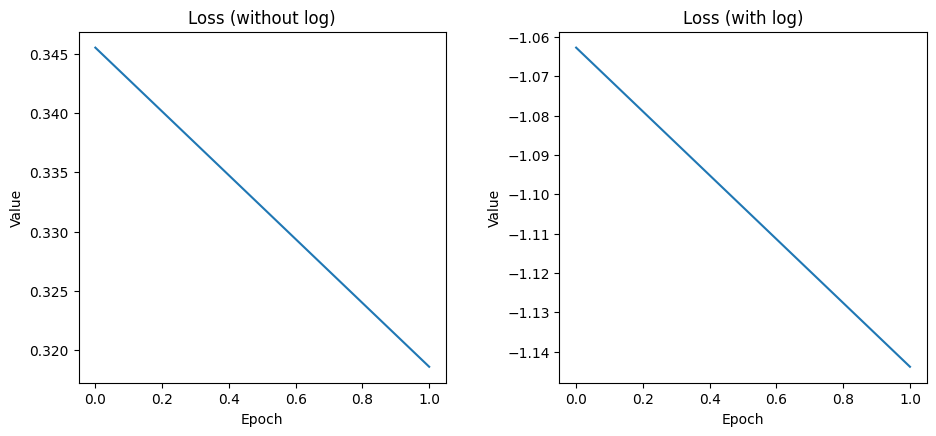

In [48]:
lr = config['train']['learning_rate']
nb_epochs = config['train']['nb_epochs']
loss_function = config['train']['loss']
loss_path = train_path / config['output']['loss']
loss = numpy.load(loss_path)
log_loss = numpy.log(loss)

print('Loss function : {}'.format(loss_function))
print('Loss path : {}'.format(loss_path))
print('Nb epochs : {}'.format(nb_epochs))
print('Learning rate : {}'.format(lr))
print('Min value : {}'.format(numpy.min(loss)))
print('Max value : {}'.format(numpy.max(loss)))
#print('Last loss values : {}'.format(loss[-5:]))

fig = matplotlib.pyplot.figure(figsize=(10, 5))

matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.title('Loss (without log)')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Value')
matplotlib.pyplot.plot(loss)

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.title('Loss (with log)')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Value')
matplotlib.pyplot.plot(log_loss)

fig.tight_layout(pad=3)

fig.show()

matplotlib.pyplot.savefig('loss.png')

### Plot image

In [49]:
eval_datas_path = train_path / 'imgs_saving' / 'eval_datas'
train_datas_path = train_path / 'imgs_saving' / 'train_datas'
dataset_path = pathlib.Path(config['dataset']['path'])
df_imgs = pandas.read_pickle(dataset_path / 'df_imgs.pkl')


no_epoch = config['train']['nb_epochs']

filename = '13.npy'

#####################################################
# Find image: Where is image ? Train datas ? Validation datas ?
input_path = dataset_path / 'input' / filename
ground_truth_path = dataset_path / 'ground_truth' / filename


epoch_eval_datas_path = eval_datas_path / 'epoch_{}'.format(no_epoch)
if not(epoch_eval_datas_path.exists()):
    raise AssertionError('Epoch {} doesnt exist'.format(no_epoch))


tmp_output_path = epoch_eval_datas_path / filename
epoch_train_datas_path = train_datas_path / 'epoch_{}'.format(no_epoch)
if not(tmp_output_path.exists()):
    tmp_output_path = epoch_train_datas_path / filename

if not(tmp_output_path.exists()):
    raise AssertionError('{} not found'.format(filename))
#####################################################

print('Input path : {}'.format(input_path))
print('Ground truth path : {}'.format(ground_truth_path))
print('Validation datas path : {}'.format(eval_datas_path))
print('Train datas path : {}'.format(train_datas_path))
print('Dataset path : {}'.format(dataset_path))
print('Output image path : {}'.format(tmp_output_path))
print('No epoch : {}'.format(no_epoch))
print('\nFilename : {}'.format(filename))
print('Output image path : {}'.format(tmp_output_path))

Input path : dataset_v1/input/13.npy
Ground truth path : dataset_v1/ground_truth/13.npy
Validation datas path : imgs_saving/eval_datas
Train datas path : imgs_saving/train_datas
Dataset path : dataset_v1
Output image path : imgs_saving/train_datas/epoch_2/13.npy
No epoch : 2

Filename : 13.npy
Output image path : imgs_saving/train_datas/epoch_2/13.npy


### Plot image

In [52]:
img_input = numpy.array(numpy.load(input_path))
img_ground_truth = numpy.array(numpy.load(ground_truth_path))
img_output = numpy.array(numpy.load(tmp_output_path))

original          Images/0.npy
blur                  (15, 15)
decimation                   2
noise (not dB)          1000.0
noise (dB)                  30
Name: 13, dtype: object
None


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/content/Utils.py:320: RuntimeWarning: invalid value encountered in divide
  seg += temp * numpy.sum(temp*ms_res) / numpy.sum(temp)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:359

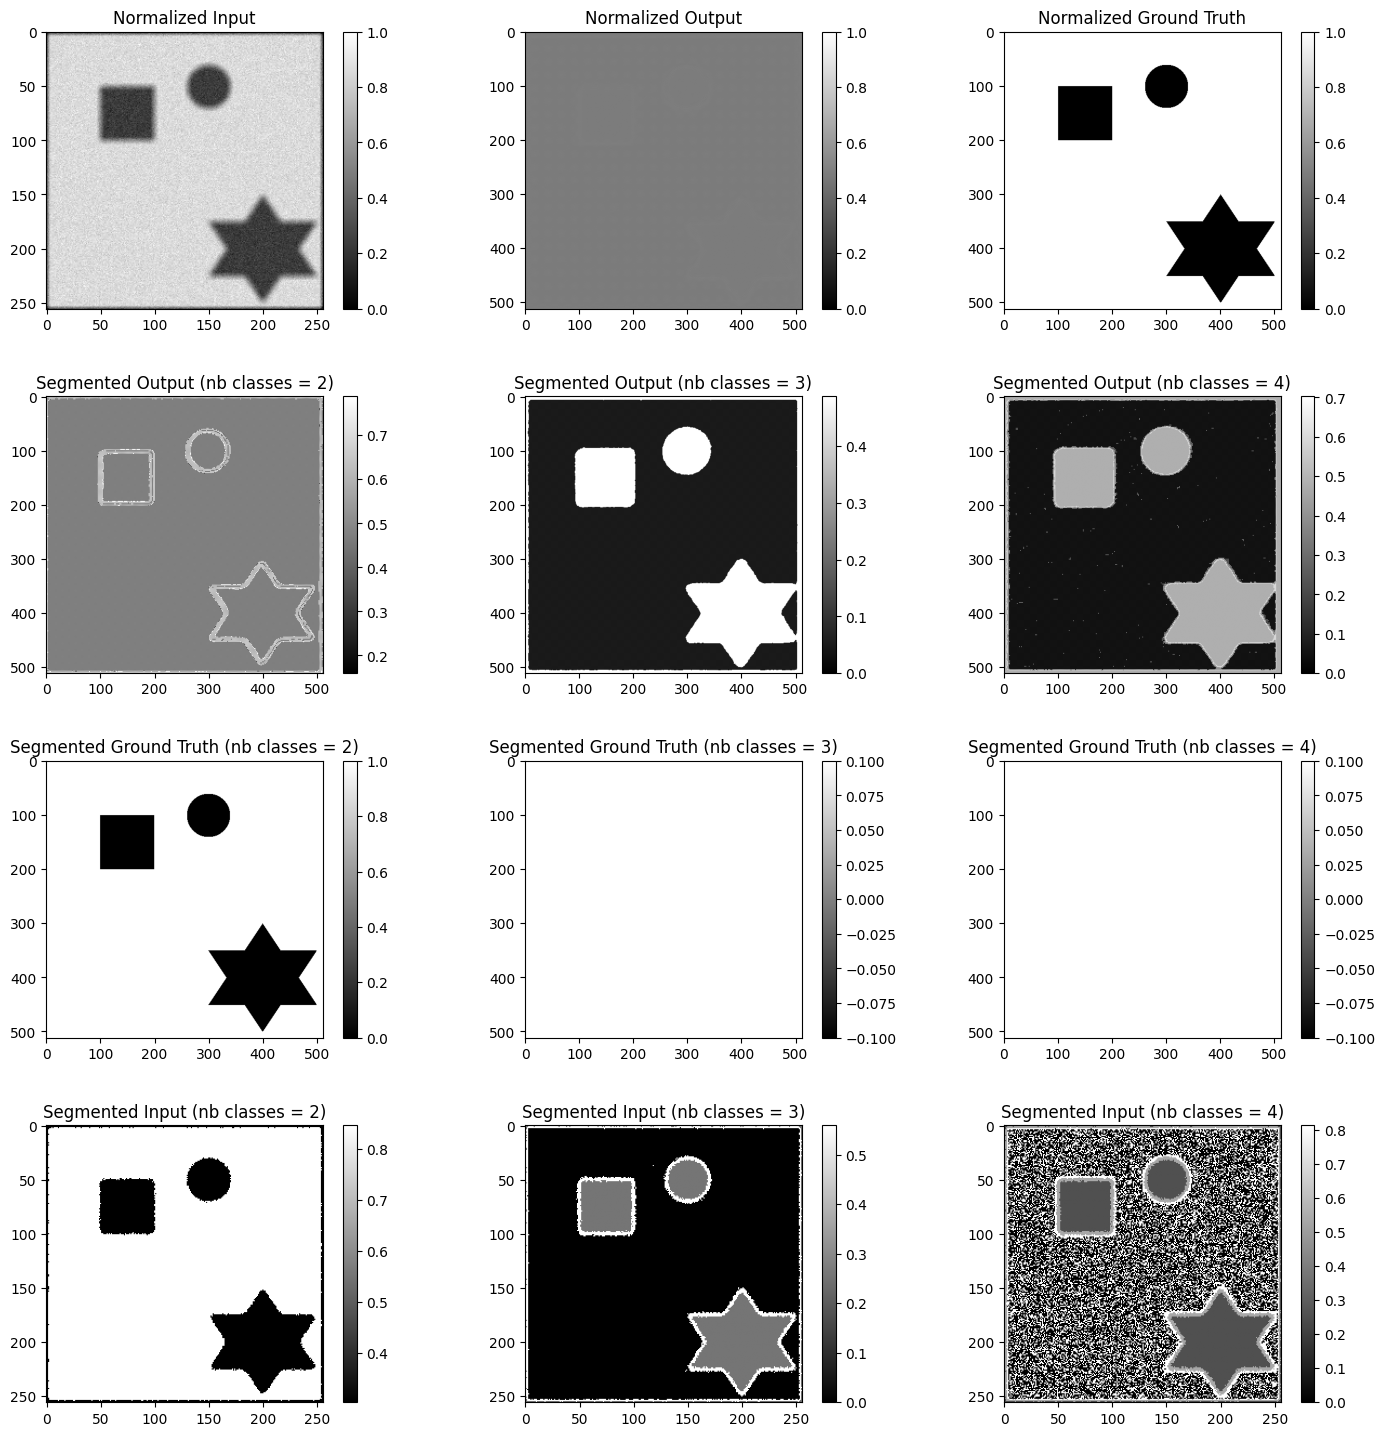

In [53]:
import Utils
print(print(df_imgs.iloc[int(input_path.stem)]))
fig = matplotlib.pyplot.figure(figsize=(15, 15))

cmap = 'gray'
#cmap = None

NB_ROWS = 4
NB_COLS = 3

# img_input = low_resolution.cpu().detach().numpy()
# img_output = restored.cpu().detach().numpy()


#print(img_input.shape)
#print(img_output.shape)
#print(img_ground_truth.shape)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 1)
matplotlib.pyplot.title('Normalized Input')
matplotlib.pyplot.imshow(img_input, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 2)
matplotlib.pyplot.title('Normalized Output')
matplotlib.pyplot.imshow(img_output, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 3)
matplotlib.pyplot.title('Normalized Ground Truth')
matplotlib.pyplot.imshow(img_ground_truth, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

##############################################################################

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 4)
k = 2
matplotlib.pyplot.title('Segmented Output (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_output, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_output,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 5)
k = 3
matplotlib.pyplot.title('Segmented Output (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_output, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_output,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 6)
k = 4
matplotlib.pyplot.title('Segmented Output (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_output, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_output,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

##############################################################################

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 7)
k = 2
matplotlib.pyplot.title('Segmented Ground Truth (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_ground_truth, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_ground_truth,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 8)
k = 3
matplotlib.pyplot.title('Segmented Ground Truth (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_ground_truth, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_ground_truth,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 9)
k = 4
matplotlib.pyplot.title('Segmented Ground Truth (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_ground_truth, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_ground_truth,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

##############################################################################

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 10)
k = 2
matplotlib.pyplot.title('Segmented Input (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_input, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_input,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 11)
k = 3
matplotlib.pyplot.title('Segmented Input (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_input, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_input,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 12)
k = 4
matplotlib.pyplot.title('Segmented Input (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_input, k)
thresholds
seg = Utils.seg_result(
    #img = img_input,
    ms_res = img_input,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

fig.tight_layout(pad=3.0)
fig.show()


#matplotlib.pyplot.savefig('loss.png')

### Plot image saving by epoch

In [54]:
img_save_every = config['output']['imgs_save']['every']
nb_epoch = config['train']['nb_epochs']

nums_epoch = [
    no_epoch for no_epoch in \
    range(img_save_every, nb_epoch+1, img_save_every) \
]

In [55]:
imgs_output = []

for no_epoch in nums_epoch:
    epoch_path = tmp_output_path.parent.parent / 'epoch_{}'.format(no_epoch)
    output_epoch_path = epoch_path / filename
    imgs_output.append(numpy.array(numpy.load(output_epoch_path)))

In [56]:
# matplotlib.pyplot.ion()
psnr = ignite.metrics.PSNR(data_range=1.0)
ssim = ignite.metrics.SSIM(data_range=1.0)


nb_images = len(imgs_output)
nb_cols = 3
nb_lines = int(nb_images / nb_cols) + 1

# fig = matplotlib.pyplot.figure(figsize=(15, 15))
fig = matplotlib.pyplot.figure()

cmap = 'gray'
#cmap = None

tensor_ground_truth = torch.tensor(img_ground_truth, dtype=torch.float)

for i in range(0, nb_images):

    no_epoch = nums_epoch[i]

    tensor_output = torch.tensor(imgs_output[i], dtype=torch.float)

    psnr.update(
        [
            tensor_ground_truth,
            tensor_output
        ]
    )

    ssim.update(
        [
            tensor_ground_truth.unsqueeze(0).unsqueeze(0),
            tensor_output.unsqueeze(0).unsqueeze(0)
        ]
    )

    matplotlib.pyplot.subplot(nb_lines, nb_cols, i+1)
    matplotlib.pyplot.title('Epoch {}; PSNR = {:.3f}; SSIM = {:.3f}'.format(no_epoch, psnr.compute(), ssim.compute()))
    matplotlib.pyplot.imshow(imgs_output[i], cmap=cmap)
    matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

    psnr.reset()
    ssim.reset()

fig.tight_layout(pad=3.0)
fig.show()

<Figure size 640x480 with 0 Axes>

### Plot model

In [57]:
import Model

In [58]:
nb_epoch = config['train']['nb_epochs']

models_pt_path = train_path / config['output']['models_save']['path']
nb_channels = config['model']['params']['nb_intermediate_channels']
nb_iterations = config['model']['params']['nb_iteration']
kernel_size = config['model']['params']['kernel_size']

print('Path of train : {}'.format(str(train_path)))
print('Path of pt file : {}'.format(str(models_pt_path)))
print('Number of channels : {}'.format(nb_channels))
print('Number of iterations : {}'.format(nb_iterations))
print('Kernel size : {}'.format(kernel_size))

model = Model.Unfolding.from_config(config)

Path of train : .
Path of pt file : models_saving
Number of channels : 1
Number of iterations : 5
Kernel size : (5, 5)


In [59]:
import torch.nn

threshold = 1e-10
value = threshold

alpha_layers = { i : [] for i in range(0, nb_iterations) }
beta0_layers = { i : [] for i in range(0, nb_iterations) }
beta1_layers = { i : [] for i in range(0, nb_iterations) }
sigma_layers = { i : [] for i in range(0, nb_iterations) }

for model_pt_file in models_pt_path.glob('*'):

    model.load_state_dict(torch.load(model_pt_file))
    parameters = list(model.named_parameters())

    count_alpha = 0
    count_beta0 = 0
    count_beta1 = 0
    count_sigma = 0

    for i in range(len(parameters)):
        name, data = parameters[i]
        if 'alpha' in name:
            alpha_layers[count_alpha].append(data.item())
            count_alpha += 1
        if 'beta0' in name:
            beta0_layers[count_beta0].append(data.item())
            count_beta0 += 1
        if 'beta1' in name:
            beta1_layers[count_beta1].append(data.item())
            count_beta1 += 1
        if 'sigma' in name:
            sigma_layers[count_sigma].append(data.item())
            count_sigma += 1

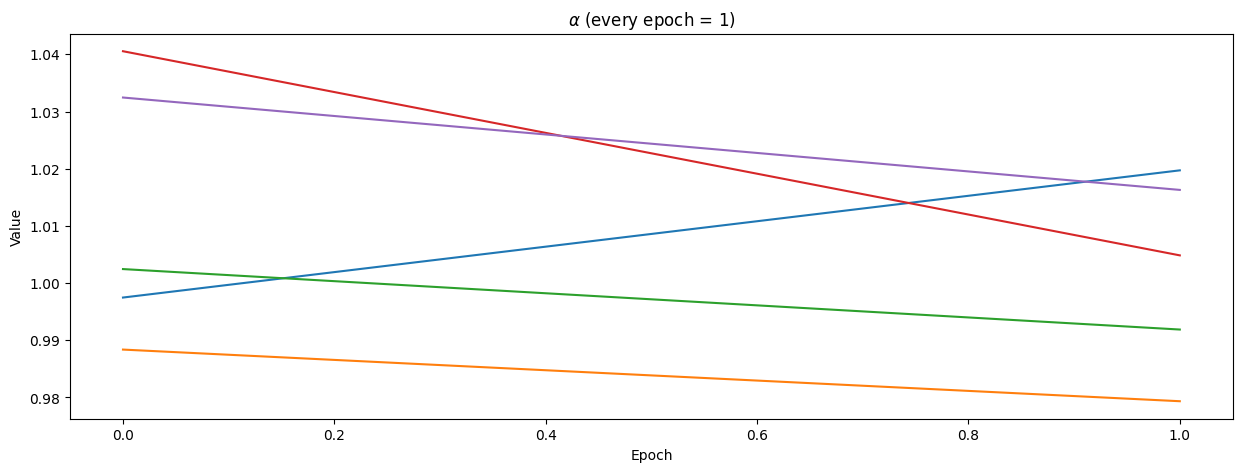

In [60]:
fig = matplotlib.pyplot.figure(figsize=(15, 5))

start = 0
end = nb_epoch
step = 1

epochs = numpy.arange(start, end, step)


matplotlib.pyplot.title('$\\alpha$ '+'(every epoch = {})'.format(step))
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Value')

# Bonée hyper paramètre dans R+
for i in range(0, nb_iterations):
    arr = numpy.array(alpha_layers[i])
    arr[arr <= threshold] = value
    matplotlib.pyplot.plot(epochs, arr[start:nb_epoch:step], label='Iteration {}'.format(i))

fig.show()

matplotlib.pyplot.savefig('alpha_per_epoch.png')

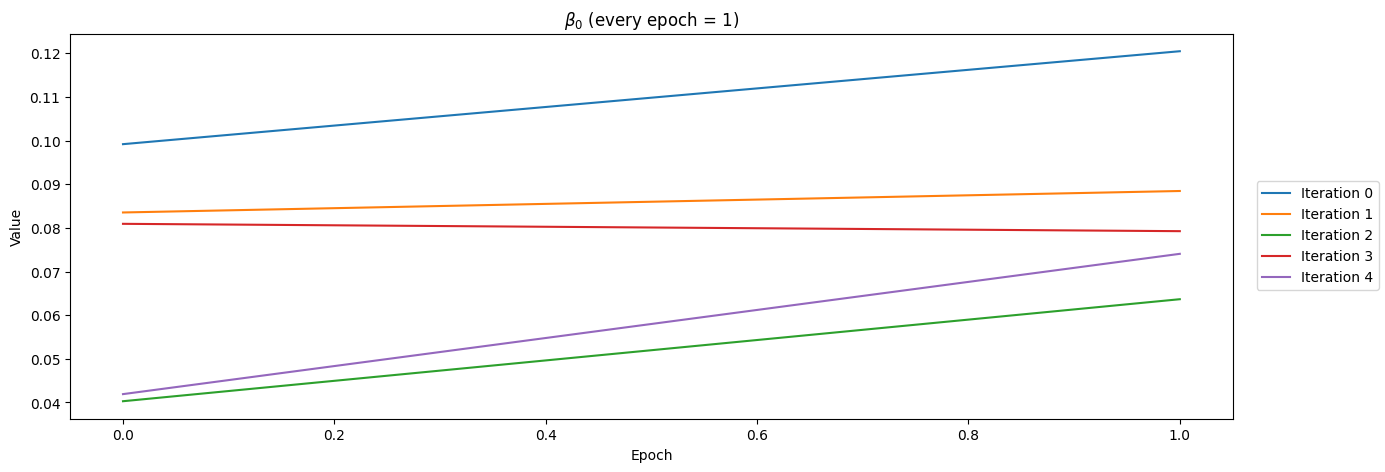

In [61]:
fig = matplotlib.pyplot.figure(figsize=(15, 5))

start = 0
end = nb_epoch
step = 1

epochs = numpy.arange(start, end, step)


matplotlib.pyplot.title('$\\beta_{0}$ '+'(every epoch = {})'.format(step))
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Value')

# Bonée hyper paramètre dans R+
for i in range(0, nb_iterations):
    arr = numpy.array(beta0_layers[i])
    arr[arr <= threshold] = value
    matplotlib.pyplot.plot(epochs, arr[start:nb_epoch:step], label='Iteration {}'.format(i))


fig.legend(loc='center right')

fig.show()

matplotlib.pyplot.savefig('beta0_per_epoch.png')

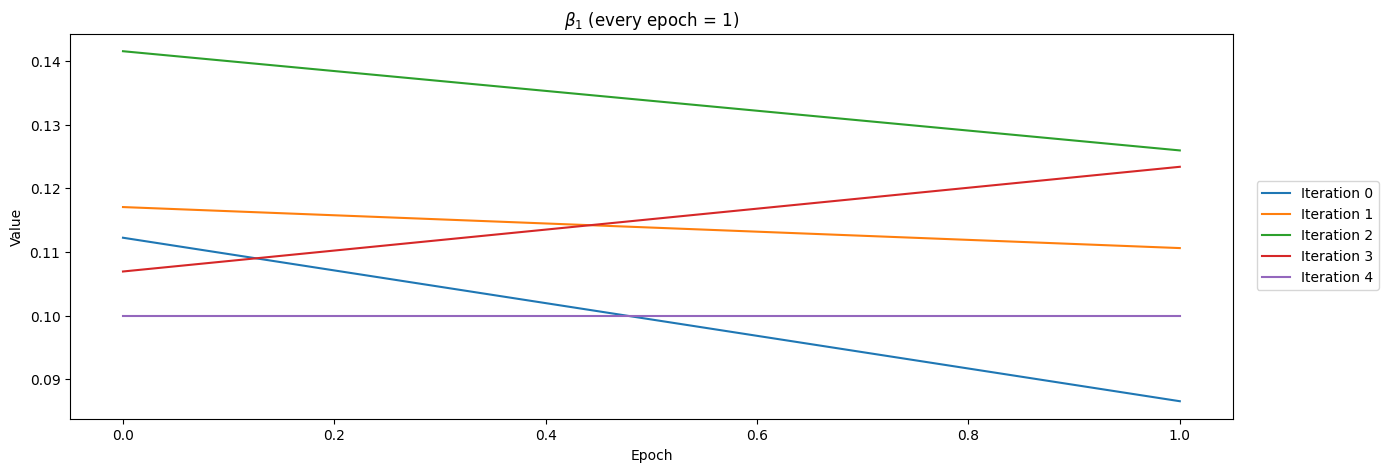

In [62]:
fig = matplotlib.pyplot.figure(
    figsize=(15, 5)
)

start = 0
end = nb_epoch
step = 1

epochs = numpy.arange(start, end, step)


# matplotlib.pyplot.subplot(2, 1, 1)

matplotlib.pyplot.title('$\\beta_{1}$ '+'(every epoch = {})'.format(step))
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Value')

# Bonée hyper paramètre dans R+
for i in range(0, nb_iterations):
    arr = numpy.array(beta1_layers[i])
    arr[arr <= threshold] = value
    matplotlib.pyplot.plot(epochs, arr[start:nb_epoch:step], label='Iteration {}'.format(i))

fig.legend(loc='center right')

fig.show()

matplotlib.pyplot.savefig('beta1_per_epoch.png')

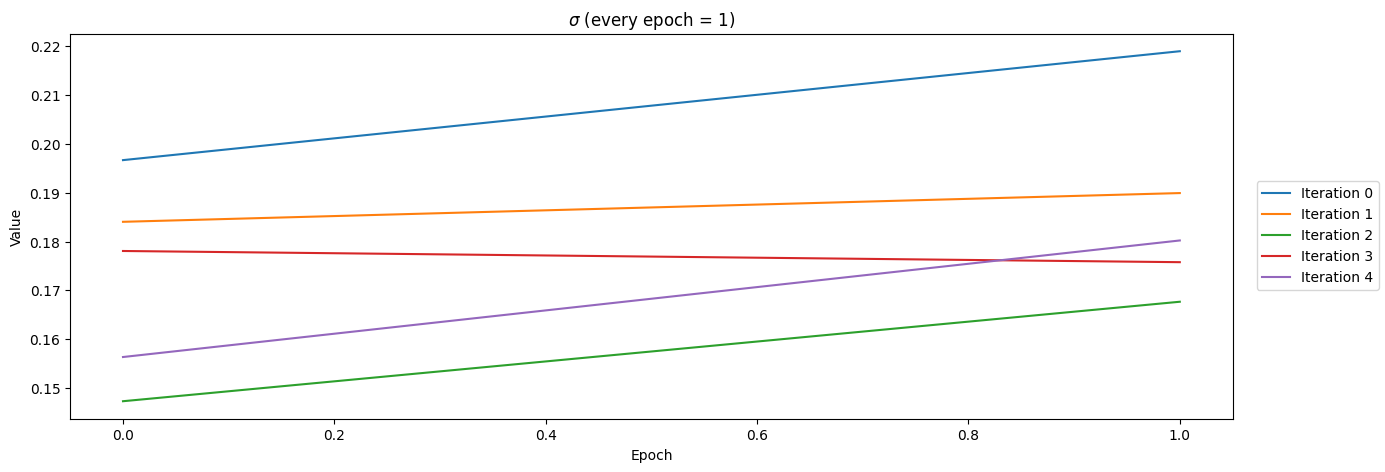

In [63]:
fig = matplotlib.pyplot.figure(figsize=(15, 5))

start = 0
end = nb_epoch
step = 1

epochs = numpy.arange(start, end, step)


matplotlib.pyplot.title('$\\sigma$ '+'(every epoch = {})'.format(step))
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Value')

# Bonée hyper paramètre dans R+
for i in range(0, nb_iterations):
    arr = numpy.array(sigma_layers[i])
    arr[arr <= threshold] = value
    matplotlib.pyplot.plot(epochs, arr[start:nb_epoch:step], label='Iteration {}'.format(i))


fig.legend(loc='center right')

fig.show()

matplotlib.pyplot.savefig('sigma_per_epoch.png')

## Evaluation

In [64]:
train_path = pathlib.Path('.')
models_pt_path = train_path / config['output']['models_save']['path']
device = config['model']['device']
no_epoch = 100
pt_file = models_pt_path / 'model_epoch_{}.pt'.format(no_epoch)
print(pt_file)

models_saving/model_epoch_100.pt


In [65]:
def eval_piece_wise_1():

    img = numpy.full(shape=(512, 512), fill_value=BACKGROUNG, dtype=numpy.float64)

    img = make_triangle(
        img,
        p1 = numpy.array([200, 100]),
        p2 = numpy.array([250, 300]),
        p3 = numpy.array([150, 300]),
        value=GEOMETRY
    )
    img = make_circle(img, numpy.array([300, 300]), 40, value=GEOMETRY)
    img = make_star(img, numpy.array([100, 300]), numpy.array([100, 300]) + 200, value=GEOMETRY)

    return img

In [66]:
def make_images_from_params(
    high_resolution: numpy.array,
    decim_row: int,
    decim_col: int,
    blur_size: int,
    blur_sigma: float,
    snr_db: float
) -> None:

    x = high_resolution
    kernel = lasp.filters.linear.gaussian_filter(
        size = blur_size,
        sigma = blur_sigma
    ) # Hx
    out = scipy.signal.convolve2d(x, kernel, mode='same')
    out = out[::decim_row, ::decim_col] # SHx
    snr = lasp.convert.snrdb_to_snr(snr_db)
    out = lasp.noise.awgn(out, snr) # SHx + n
    normalized = lasp.utils.normalize(out)

    return normalized

In [67]:
original = eval_piece_wise_1()

blur_size, blur_sigma = 15, 15
decim_row, decim_col = 2, 2
snr_db = 20

low_resolution = make_images_from_params(
    high_resolution=original,
    decim_row = decim_row,
    decim_col = decim_col,
    blur_size = blur_size,
    blur_sigma = blur_sigma,
    snr_db = snr_db
)

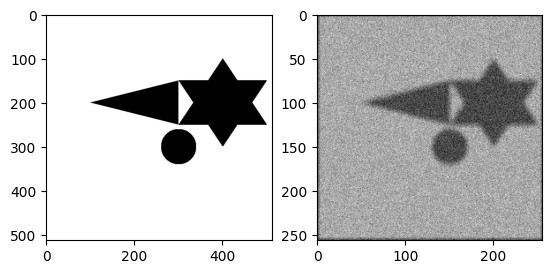

In [68]:
figure = matplotlib.pyplot.figure()

matplotlib.pyplot.subplot(1, 2, 1)
_ = matplotlib.pyplot.imshow(original, cmap=CMAP)

matplotlib.pyplot.subplot(1, 2, 2)
_ = matplotlib.pyplot.imshow(low_resolution, cmap=CMAP)

figure.show()

In [69]:
low_resolution = torch.tensor(
    data = low_resolution,
    device = device,
    dtype = torch.float
)

restored = model(
    low_resolution,
    decim_row,
    decim_col
)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/content/Utils.py:320: RuntimeWarning: invalid value encountered in divide
  seg += temp * numpy.sum(temp*ms_res) / numpy.sum(temp)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:359

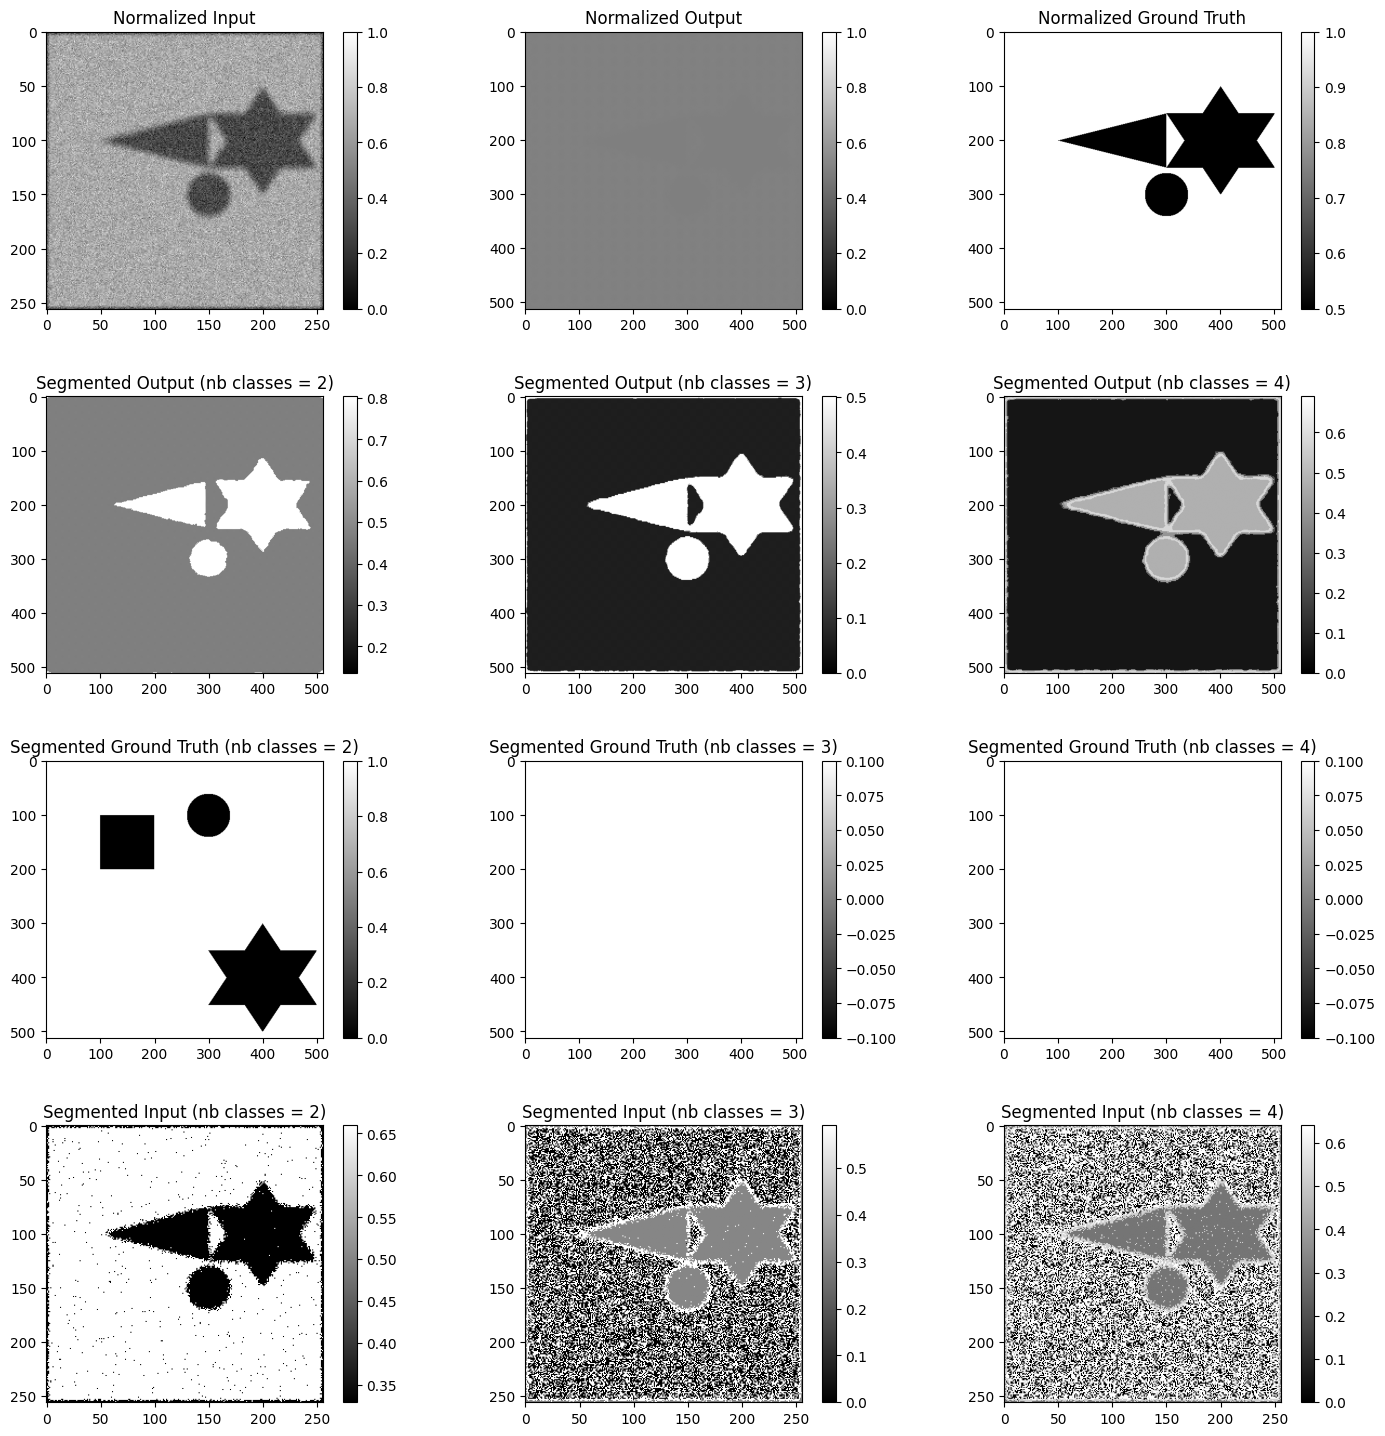

In [70]:
fig = matplotlib.pyplot.figure(figsize=(15, 15))

cmap = 'gray'
#cmap = None

NB_ROWS = 4
NB_COLS = 3

img_input = low_resolution.cpu().detach().numpy()
img_output = restored.cpu().detach().numpy()


#print(img_input.shape)
#print(img_output.shape)
#print(img_ground_truth.shape)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 1)
matplotlib.pyplot.title('Normalized Input')
matplotlib.pyplot.imshow(img_input, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 2)
matplotlib.pyplot.title('Normalized Output')
matplotlib.pyplot.imshow(img_output, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 3)
matplotlib.pyplot.title('Normalized Ground Truth')
matplotlib.pyplot.imshow(original, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

##############################################################################

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 4)
k = 2
matplotlib.pyplot.title('Segmented Output (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_output, k)
seg = Utils.seg_result(
    ms_res = img_output,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 5)
k = 3
matplotlib.pyplot.title('Segmented Output (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_output, k)
seg = Utils.seg_result(
    ms_res = img_output,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 6)
k = 4
matplotlib.pyplot.title('Segmented Output (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_output, k)
seg = Utils.seg_result(
    ms_res = img_output,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

##############################################################################

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 7)
k = 2
matplotlib.pyplot.title('Segmented Ground Truth (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_ground_truth, k)
seg = Utils.seg_result(
    ms_res = img_ground_truth,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 8)
k = 3
matplotlib.pyplot.title('Segmented Ground Truth (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_ground_truth, k)
seg = Utils.seg_result(
    ms_res = img_ground_truth,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 9)
k = 4
matplotlib.pyplot.title('Segmented Ground Truth (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_ground_truth, k)
seg = Utils.seg_result(
    ms_res = img_ground_truth,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

##############################################################################

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 10)
k = 2
matplotlib.pyplot.title('Segmented Input (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_input, k)
seg = Utils.seg_result(
    ms_res = img_input,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 11)
k = 3
matplotlib.pyplot.title('Segmented Input (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_input, k)
seg = Utils.seg_result(
    ms_res = img_input,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

matplotlib.pyplot.subplot(NB_ROWS, NB_COLS, 12)
k = 4
matplotlib.pyplot.title('Segmented Input (nb classes = {})'.format(k))
thresholds = Utils.thresholding_kmeans(img_input, k)
seg = Utils.seg_result(
    ms_res = img_input,
    thresholds = thresholds,
    k = k
)
matplotlib.pyplot.imshow(seg, cmap=cmap)
matplotlib.pyplot.colorbar(orientation='vertical', fraction=0.046)

fig.tight_layout(pad=3.0)
fig.show()


#matplotlib.pyplot.savefig('loss.png')